In [1]:
import numpy as np
import pandas as pd
import glob
from pandas.errors import EmptyDataError
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


In [2]:
# read the txt files and store them in a 'stocks' dictionary
def read_stock_data(PATH):
    PATH_LIST = glob.glob((PATH + '*.txt'))
    stocks = {}
    # we store multiple dataframes in a dictionary, where (key,value) = (stock_name,dataframe)
    for i, stock_path in enumerate(PATH_LIST):
        try:
            stock_file_name = os.path.basename(stock_path)     # extract file name from directory, eg xxx.us.txt
            stock_name = os.path.splitext(stock_file_name)[0]  # extract xxx.us
            stock_name = stock_name.split('.')[0]              # extract xxx
            stocks[stock_name] = pd.read_csv(stock_path, sep=',', parse_dates=['Date'])
        # drop the empty files
        except EmptyDataError:  
            pass
    return stocks

In [3]:
##  Preprocess data

# delete rows that include Price columns with zeros or negative values
def remove_zeros(df):
    cols = ['Open','High','Low','Close','Volume']
    df[df[cols]<=0] = np.nan
    df.dropna(inplace=True)
    df['Volume'] = df['Volume'].astype(int)
    return df

# check if the all time high stock price comes before all time low price
def high_before_low(df):
    low_idx  = df['Low'].idxmin()
    high_idx = df['High'].idxmax()
    if low_idx > high_idx: return True
    return False

# check if the stock is in the stock market for less than a year
def small_presence(df):
    if len(df)<365: return True
    return False

# check if a stock's all time high value is less than 10 dollars
def low_peak(df):
    high = df['High'].max()
    if high<10: return True
    return False

# filter out rows, where the daily volume is less than 100 units
def filter_low_volume(df):
    return df[df['Volume']>=100]

def preprocessing(stocks):
    for name in list(stocks.keys()):
        if high_before_low(stocks[name]): del stocks[name]; continue
        if small_presence(stocks[name]): del stocks[name]; continue
        if low_peak(stocks[name]): del stocks[name]; continue   

        stocks[name] = remove_zeros(stocks[name])
        stocks[name] = filter_low_volume(stocks[name])
        # convert Dates to datetime format
        stocks[name]['Date'] = pd.to_datetime(stocks[name]['Date']).dt.date
        # remove OpenInt column
        stocks[name].drop(columns=['OpenInt'], inplace=True)
        
    return stocks


In [4]:
class Move:
    def __init__(self, move, stocks):
        self.date       = move[0]
        self.order      = move[1]
        self.stock_name = move[2].lower()
        self.vol        = move[3]
        self.stock      = stocks[self.stock_name]
        self.row        = self.stock.loc[self.stock['Date']==self.date]
        self.order1     = move[1].split('-')[0] == 'buy'      # if buy true else false
        self.order2     = move[1].split('-')[1].capitalize()  # Open, Close, Low, High
    
    # method for optimal volume calculation
    def calc_vol(self, account):
        if self.row.empty:
            print(f"No data found for {self.stock_name} on {self.date}")
            return 0 
        # if buy order, calculate the maximum volume that capital can buy
        if self.order1:
            if self.order2 not in self.row.columns:
                print(f"Column {self.order2} not found in data for {self.stock_name} on {self.date}")
                return 0
            price = self.row[self.order2].iloc[0]
            afforded_vol = int(account.capital // price)
            max_vol = int(0.1*self.row['Volume'].iloc[0])
            self.vol = min(afforded_vol, max_vol)
        else:
            # if sell order, return all owned volume of the stock
            self.vol = account.owned_stock_volume[self.stock_name]
        return self.vol
    
    # check for empty row
    def empty_row(self):
        if self.row.empty:
            print('The Date you inserted in not included')
            return True
        return False
    
    # check if transanction exceeds the daily trade volume
    def exceeds_daily_volume(self, msg=True):
        if self.vol > 0.1 * self.row['Volume'].iloc[0]:
            if msg: print(f'This order exceeds the 10% volume of {self.stock_name} stock for the day')
            return True
        return False
    
    # check if transaction exceeds current capital
    def exceeds_capital(self,account, msg=True):
        capital_required = self.vol * self.row[self.order2].iloc[0]
        if account.capital < capital_required:
            if msg: print('This buying order exceeds capital')
            return True
        return False
    
    # check if the sold stock exists in the account
    def stocks_not_owned(self,account, msg=True):
        if self.stock_name not in account.owned_stock_volume.keys(): 
            if msg: print(f'There are no {self.stock_name} stocks in the account')
            return True
        return False

    # check if the sold volume exceeds the existing stock volume
    def exceeds_owned_volume(self,account, msg=True):
        if self.vol > account.owned_stock_volume[self.stock_name]:
            if msg: print('This selling order exceeds the owning amount of stocks')
            return True
        return False
            
    # implement a buying order
    def buying_order(self, account):
        # update capital
        capital_required = self.vol * self.row[self.order2].iloc[0]
        account.capital -= capital_required
        # update owned stocks volume
        if self.stock_name in account.owned_stock_volume.keys():
            account.owned_stock_volume[self.stock_name] += self.vol
        else:
            account.owned_stock_volume[self.stock_name] = self.vol
        return account

    # implement a selling order
    def selling_order(self,account):
        # update capital
        account.capital += self.vol * self.row[self.order2].iloc[0]
        # update the owned stocks volume
        account.owned_stock_volume[self.stock_name] -= self.vol
        return account


In [5]:
class Account:
    def __init__(self, INITIAL_CAPITAL):
        self.capital            = INITIAL_CAPITAL
        self.net_value          = 0.0
        self.owned_stock_volume = {}
        self.owned_stock_prices = {}
        
    # print the current portfolio
    def report(self):
        printed_volume      = self.owned_stock_volume
        printed_stock_price = self.owned_stock_prices
        for key, value in list(printed_volume.items()):
            if value == 0:
                del printed_volume[key]
                del printed_stock_price[key]
        print(f'Account Information: Capital: {self.capital}, Net Value: {self.net_value}, Stocks owned: {printed_volume}, Stock Price: {printed_stock_price}')    
        
    # update net value on a given date
    def update_net(self, move):
        self.net_value = 0.0
        for i, item in enumerate(self.owned_stock_volume):
            self.owned_stock_prices[item] = move.row['Close'].iloc[0]
            # update the net value of the account
            self.net_value += self.owned_stock_volume[item] * self.owned_stock_prices[item]
        self.net_value += self.capital
        # print the new portfolio information
#         self.report()
        return self

In [6]:
def trading_strategy(stocks, num_pairs):
    for name, data in stocks.items():
        data['DailyReturnPct'] = (data['Close'] - data['Open']) / data['Open']
        data['StockName'] = name
    stacked_stocks = pd.concat(stocks.values())
    stacked_stocks = stacked_stocks.sort_values(by='DailyReturnPct', ascending=False)
    top_returns = stacked_stocks.head(num_pairs)
    top_returns = top_returns.sort_values(by='Date')
    return top_returns


In [7]:
def process_move(curr_move, curr_account):
    # check for empty row
    if curr_move.empty_row(): return curr_account      
    # check for <= 10% of daily stock volume
    if curr_move.exceeds_daily_volume(): 
        return curr_account  
    
    # BUY
    if curr_move.order1:  # e.g. buy-low => order1=buy and order2=low
        # check if the buying order exceeds the current capital
        if curr_move.exceeds_capital(curr_account): return curr_account 
        curr_account = curr_move.buying_order(curr_account)
    # SELL
    else: 
        # check if there are stocks of the kind in the account
        if curr_move.stocks_not_owned(curr_account): return curr_account 
        # check if there are enough stocks for the sell
        if curr_move.exceeds_owned_volume(curr_account): return curr_account 
        curr_account = curr_move.selling_order(curr_account)
    return curr_account


In [8]:
# input dataframe, output a nested list, where every inner list is a move
def create_moves(df):
    moves = []
    dates = df['Date'].tolist()
    open_prices = df['Open'].tolist()
    close_prices = df['Close'].tolist()
    names = df['StockName'].tolist()
    vol = 0
    for i in range(len(dates)):
        moves.append([dates[i], 'buy-open', names[i], vol])
        moves.append([dates[i], 'sell-close',names[i], vol])
    
    return moves

In [9]:
def skip_transaction(skip, move):
    # move==buy and affordable volume = 0
    if move.order1==True and move.calc_vol(cur_account)==0:  return True
    # move==sell and previous move was buy
    if move.order1==False and skip==True: return True
    return False

In [10]:
# implement the created moves
def execute_transactions(moves, stocks, cur_account):
    skip  = False
    final_moves = []
    graph = [[],[],[]]
    for i in range(len(moves)):
        cur_move = Move(moves[i], stocks)
        skip = skip_transaction(skip, cur_move)
        if skip:
            if i==len(moves):
                cur_account.report()
            continue
            
        moves[i][3] = cur_move.calc_vol(cur_account)
        print(f'Move {i+1}: {cur_move.date}, {cur_move.order}, {cur_move.stock_name}, {cur_move.vol}')
        cur_account = process_move(cur_move, cur_account)
        cur_account.update_net(cur_move)
        graph[0].append(moves[i][0])
        graph[1].append(cur_account.capital)
        graph[2].append(cur_account.net_value)
        final_moves.append(moves[i])
        cur_account.report()
    
    return final_moves, graph

In [11]:
def create_graph(graph):
    years = graph[0]
    balance = graph[1]  
    portfolio = graph[2] 

    plt.fill_between(years, portfolio, label='Portfolio', color='orange')
    plt.fill_between(years, balance, label='Balance', color='darkblue')

    plt.yscale('log')
    plt.title('Valuation')
    plt.legend(loc='upper left')
    plt.show()


In [12]:
# save a txt file of the moves in the same folder
def save_file(PATH, moves):
    N = len(moves)
    # Writing to the file
    with open(PATH, 'w') as file:
        file.write(f'{N}\n')
        for move in moves:
            file.write(' '.join(map(str, move)) + '\n')
    

In [13]:
PATH_READ = 'C:/Users/milio/Desktop/datasets/PythonProject/Stocks/'
INITIAL_CAPITAL = 1.0
TRANSACTIONS = 1000
if TRANSACTIONS==1000:
    PATH_WRITE = 'small.txt'
else:
    PATH_WRITE = 'large.txt'

stocks = read_stock_data(PATH_READ)
stocks = preprocessing(stocks)
move_rows = trading_strategy(stocks, num_pairs=int(TRANSACTIONS/2))
cur_account = Account(INITIAL_CAPITAL)
initial_moves = create_moves(move_rows)


Move 1: 1970-02-09, buy-open, mo, 68
Account Information: Capital: 0.005840000000000067, Net Value: 1.49504, Stocks owned: {'mo': 68}, Stock Price: {'mo': 0.0219}
Move 2: 1970-02-09, sell-close, mo, 68
Account Information: Capital: 1.49504, Net Value: 1.49504, Stocks owned: {}, Stock Price: {}
Move 3: 1970-04-20, buy-open, mo, 102
Account Information: Capital: 0.0038000000000000256, Net Value: 2.2376, Stocks owned: {'mo': 102}, Stock Price: {'mo': 0.0219}
Move 4: 1970-04-20, sell-close, mo, 102
Account Information: Capital: 2.2376, Net Value: 2.2376, Stocks owned: {}, Stock Price: {}
Move 5: 1970-05-28, buy-open, mo, 153
Account Information: Capital: 0.0007399999999999629, Net Value: 3.3514399999999998, Stocks owned: {'mo': 153}, Stock Price: {'mo': 0.0219}
Move 6: 1970-05-28, sell-close, mo, 153
Account Information: Capital: 3.3514399999999998, Net Value: 3.3514399999999998, Stocks owned: {}, Stock Price: {}
Move 7: 1973-06-19, buy-open, wmt, 195
Account Information: Capital: 0.009139

Move 441: 2008-12-02, buy-open, newt, 3067
Account Information: Capital: 108272946.83576995, Net Value: 108276647.47796994, Stocks owned: {'newt': 3067}, Stock Price: {'newt': 1.2066}
Move 442: 2008-12-02, sell-close, newt, 3067
Account Information: Capital: 108276647.47796994, Net Value: 108276647.47796994, Stocks owned: {}, Stock Price: {}
Move 443: 2008-12-02, buy-open, bc, 245364
Account Information: Capital: 107793452.15276994, Net Value: 108505400.33516994, Stocks owned: {'bc': 245364}, Stock Price: {'bc': 2.9016}
Move 444: 2008-12-02, sell-close, bc, 245364
Account Information: Capital: 108505400.33516994, Net Value: 108505400.33516994, Stocks owned: {}, Stock Price: {}
Move 445: 2008-12-03, buy-open, ppc, 2217687
Account Information: Capital: 108220427.55566995, Net Value: 108689801.00921994, Stocks owned: {'ppc': 2217687}, Stock Price: {'ppc': 0.21165}
Move 446: 2008-12-03, sell-close, ppc, 2217687
Account Information: Capital: 108689801.00921994, Net Value: 108689801.00921994

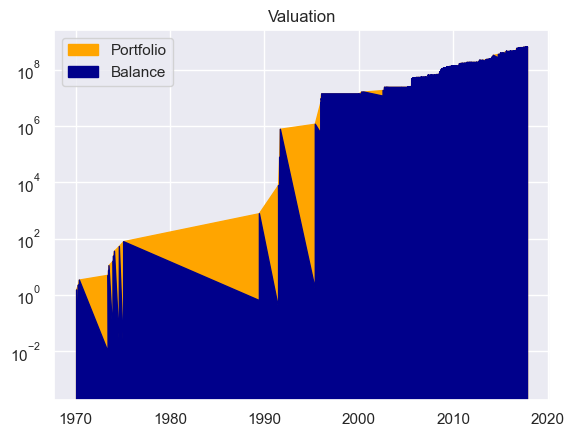

In [14]:
moves, graph = execute_transactions(initial_moves, stocks, cur_account)
create_graph(graph)
save_file(PATH_WRITE, moves)